In [1]:
import sys
sys.path.append('../scripts/')
from sarsa import *

In [2]:
class SarsaLambdaAgent(SarsaAgent):  ###sarsalambda1agent
    def __init__(self, time_interval, estimator, puddle_coef=100,  alpha=0.5, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, dev_borders=[0.1,0.2,0.4,0.8], lmd=0.9):  #nstepをlmdに
        super().__init__(time_interval, estimator, puddle_coef,  alpha, widths, lowerleft, upperright, dev_borders)
        
        self.s_trace = [] 
        self.a_trace = [] #r_traceは不要なので消す
        self.lmd = lmd    #nstepからlmdに変更
        
    def set_action_value_function(self):
        ss = {}
        for index in self.indexes: 
            ss[index] = StateInfo(len(self.actions))
            for i, a in enumerate(self.actions):
                ss[index].q[i] = -1000.0
                
        return ss
        
    def decision(self, observation=None):
        ##終了処理##
        if self.update_end:  return 0.0, 0.0
        if self.in_goal:          self.update_end = True
        
        ##カルマンフィルタの実行##
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.estimator.observation_update(observation)
        
        ##行動決定と報酬の処理##
        s_, a_ = self.policy(self.estimator.pose)
        r = self.time_interval*self.reward_per_sec()
        self.total_reward += r             #r_traceの処理を削除
        
        ##Q学習と現在の状態と行動の保存##
        self.q_update(r, s_, a_) #引数を変更
        self.s, self.a = s_, a_
        self.s_trace.append(s_)
        self.a_trace.append(a_)

        ##出力##
        self.prev_nu, self.prev_omega = self.actions[a_]
        return self.actions[a_]

    def q_update(self, r, s_, a_):
        if self.s == None: return
        
        q = self.ss[self.s].q[self.a]
        v = self.ss[self.s].max_q()
        
        v_ = self.final_value if self.in_goal else self.ss[s_].max_q()
        diff_q = r + v_ - q
        diff_v = r + v_ - v
        
        for i in range(1,len(self.s_trace)):
            s, a = self.s_trace[-i-1], self.a_trace[-i-1] #後ろからi番目の要素を更新
            self.ss[s].q[a] += self.alpha*diff_v*(self.lmd**i)
        
        s, a = self.s_trace[-1], self.a_trace[-1]
        self.ss[s].q[a] += self.alpha*diff_q

In [3]:
class WarpRobot2(WarpRobot):         
    def __init__(self, *args, **kwargs): 
        super().__init__(*args, **kwargs)
        
    def choose_pose(self):
        return np.array([random.random()*8-4, random.random()*8-4, random.random()*2*math.pi]).T
    
    def one_step(self, time_interval):
        if self.agent.update_end:
            with open("log.txt", "a") as f:
                f.write("{}\n".format(self.agent.total_reward + self.agent.final_value))
            self.reset()
            return
        elif len(self.poses) >= 300:
            with open("log.txt", "a") as f:
                f.write("DNF\n")
            self.reset()
            return
        
        super().one_step(time_interval)

<IPython.core.display.Javascript object>


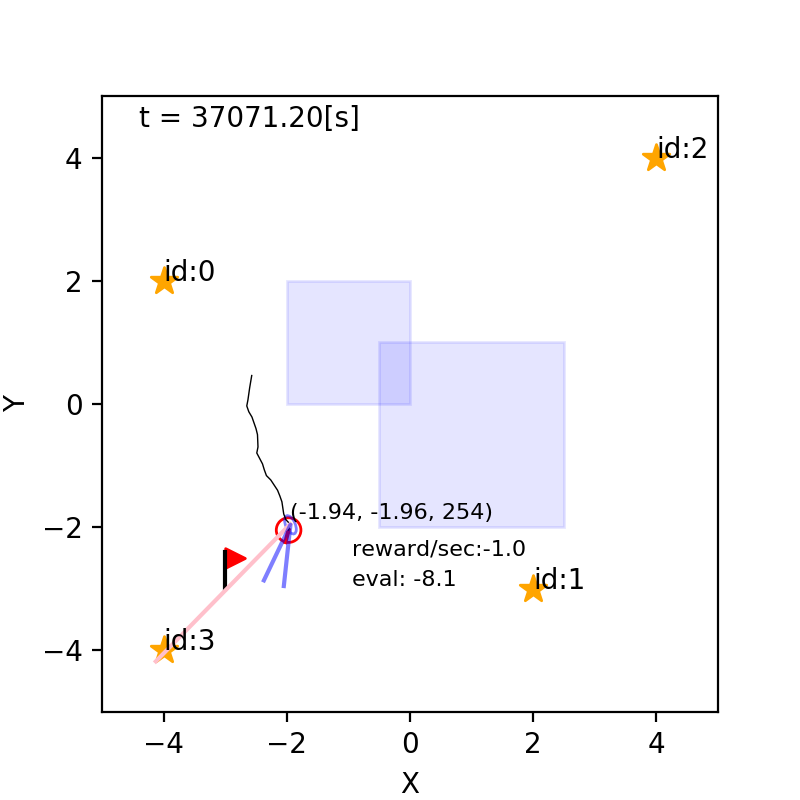

In [4]:
def trial(): 
    time_interval = 0.1
    world = PuddleWorld(400000, time_interval, debug=False)  #長時間アニメーション時間をとる

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    for ln in [(-4,2), (2,-3), (4,4), (-4,-4)]: m.append_landmark(Landmark(*ln))
    world.append(m)   

    ##ゴールの追加##
    goal = Goal(-3,-3) 
    world.append(goal)
    
    ##水たまりの追加##
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1)) 

    ##ロボットを1台登場させる##
    init_pose = np.array([3, 3, 0]).T
    kf = KalmanFilter(m, init_pose)
    a = SarsaLambdaAgent(time_interval, kf)
    r = WarpRobot2(init_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0), 
              agent=a, color="red", bias_rate_stds=(0,0))
    world.append(r)
    
    world.draw()
    return a
    
a = trial()